In [1]:
from math import sqrt

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as th
from torch import vstack, hstack, tensor
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset


from quantum import coherent_ket
from loss import povm_loss
from utils import random_stiefel, unstack, check_povm_validity, grid_points, plot_matrix, on_stiefel

In [2]:
M = 20  # number of POVM outcomes
N = 30  # Hilbert space dimension

### True POVMs

In [3]:
# random POVM
# true_povm_factors = random_stiefel(M*N, N) 
# true_povm_factors = unstack(true_povm_factors, M=M, N=N) 
# true_povm = [E.H @ E for E in true_povm_factors]  # true POVM for data generation

# binary detection POVM
# M = 2
# E1 = th.diag( tensor([1.0] + [0.0]*(N-1), dtype=th.complex128) )
# E2 = th.eye(N) - E1
# true_povm = [E1, E2]

# PNR POVM
true_povm = []
for m in range(M):
    povm_diag = th.zeros(N, dtype=th.complex128)
    povm_diag[m] = 1.0
    true_povm.append( th.diag(povm_diag) )

print(f'Is true POVM valid? {"Yes" if check_povm_validity(true_povm) else "No"}')

POVM elements do not sum to identity.
Is true POVM valid? No


### Probe states

In [4]:
num_probes = 30
max_amp = sqrt(3.0)   # max coordinate in phase space that will be spanned in one direction is max_amp^2

# generate num_probes^2 state probes each from circles of increasing radius
# complex_amps = np.array([circle_points(num_probes, R=R) for R in np.linspace(0.1, max_amp, num_probes) ]).flatten()
complex_amps = grid_points(num_probes, xlim=(-max_amp, max_amp), ylim=(-max_amp, max_amp), dtype=th.complex128)

probes = vstack([ coherent_ket(alpha, N) for alpha in complex_amps ])

print(f"Shape of probes is: {list(probes.shape)} should be {[num_probes**2, N]}.")

Shape of probes is: [900, 30] should be [900, 30].


### Target matrix 

Shape of targets is: [900, 20] should be [900, 20].


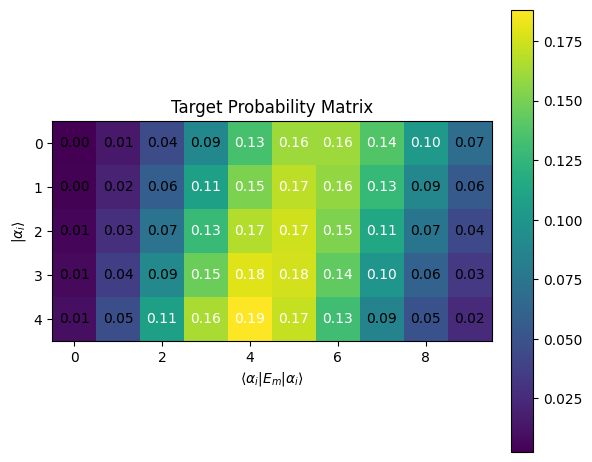

In [5]:
# targets = []
# for probe in probes:
#     probe_probs = []
#     for E in true_povm:
#         prob = (probe.conj().T @ E @ probe).real
#         probe_probs.append(prob)
#     probe_probs = tensor(probe_probs)
#     targets.append(probe_probs)

# targets = vstack(targets).real
targets = th.einsum("bi,mij,bj->bm", probes.conj(), th.stack(true_povm), probes).real

print(f"Shape of targets is: {list(targets.shape)} should be {[num_probes**2, M]}.")

for i in range(targets.shape[0]):
    if th.sum(targets[0]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")


plot_matrix(
    targets.numpy()[:5, :10],
    title="Target Probability Matrix",
    cmap="viridis",
    show_values= not False,
    xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
    ylabel=r"$|\alpha_i\rangle$",
    colorbar=True,
    figsize=(6, 5),
    vmin=None,
    vmax=None
)

### Training

In [ ]:
lam = 1*1e-3  # regularization weight
current_lr = 0.001  # learning rate
lr_decay = 0.999  # learning rate decay factor
device = 'cuda'

factors = random_stiefel(M*N, N).to(device)  # initialize POVM factors
print(f"|| I - ΣAi†Ai ||2: {th.linalg.norm(th.eye(N).to(device) - sum(factors), ord=2).item()}")
factors.requires_grad = True

# optimizer = SGD([factors], lr=initial_lr)
# scheduler = ExponentialLR(optimizer, gamma=lr_decay) # Decay LR by gamma every time called

probes = probes.to(device)
targets = targets.to(device)
dataset = TensorDataset(probes, targets)

# Create DataLoader
batch_size = 75
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

True
|| I - ΣAi†Ai ||2: 28.999999586668384


### Training loop

In [78]:
iterations = 250
I = th.eye(2*N, dtype=th.complex128).to(device) # identity matrix for retraction step
losses = []
lr_vals = []

for step in tqdm(range(iterations), desc="Learning POVM"):
    lr_vals.append(current_lr)
    completeness_cond = th.linalg.norm(th.eye(N).to(device) - factors.H @ factors, ord=2).item()
    if completeness_cond > 1e-5:
        print(f"Warning: POVM not valid at step {step+1} is: {completeness_cond}") 
    
    batch_losses = []

    for probes_batch, targets_batch in loader:

        # Compute batch loss
        L = povm_loss(targets_batch, factors, probes_batch, lam)

        L.backward()

        with th.no_grad():
            # --- Retraction step ---
            normed_G = factors.grad / th.linalg.norm(factors.grad, ord=2)
            A = th.hstack([normed_G, factors])      # (M*N, 2N)
            B = th.hstack([factors, -normed_G])     # (M*N, 2N)

            # Conjugate gradient retraction
            inv_term = th.linalg.inv(I + (current_lr/2)*(B.conj().T @ A))
            st_grad = A @ inv_term @ B.conj().T @ factors
            factors -= current_lr * st_grad.data  # .data to avoid tracking in autograd
        
        # Zero gradients
        factors.grad.zero_()
        
        batch_losses.append(L.item())
        current_lr *= lr_decay  # decay learning rate manually

    #scheduler.step()
    losses.append(sum(batch_losses) / len(batch_losses))

Learning POVM:   0%|          | 0/250 [00:00<?, ?it/s]

Learning POVM:   0%|          | 1/250 [00:00<01:06,  3.77it/s]

Learning POVM:   1%|          | 2/250 [00:00<01:02,  3.95it/s]

Learning POVM:   1%|          | 3/250 [00:00<01:00,  4.06it/s]

Learning POVM:   2%|▏         | 4/250 [00:00<01:01,  4.03it/s]

Learning POVM:   2%|▏         | 5/250 [00:01<01:00,  4.06it/s]

Learning POVM:   2%|▏         | 6/250 [00:01<00:59,  4.13it/s]

Learning POVM:   3%|▎         | 7/250 [00:01<00:59,  4.10it/s]

Learning POVM:   3%|▎         | 8/250 [00:01<00:59,  4.10it/s]

Learning POVM:   4%|▎         | 9/250 [00:02<00:58,  4.15it/s]

Learning POVM:   4%|▍         | 10/250 [00:02<00:57,  4.20it/s]

Learning POVM:   4%|▍         | 11/250 [00:02<00:57,  4.19it/s]

Learning POVM:   5%|▍         | 12/250 [00:02<00:57,  4.14it/s]

Learning POVM:   5%|▌         | 13/250 [00:03<00:57,  4.09it/s]

Learning POVM:   6%|▌         | 14/250 [00:03<00:56,  4.15it/s]

Learning POVM:   6%|▌         | 15/250 [00:03<00:56,  4.13it/s]

Learning POVM:   6%|▋         | 16/250 [00:03<00:56,  4.12it/s]

Learning POVM:   7%|▋         | 17/250 [00:04<00:57,  4.06it/s]

Learning POVM:   7%|▋         | 18/250 [00:04<00:56,  4.10it/s]

Learning POVM:   8%|▊         | 19/250 [00:04<00:57,  4.04it/s]

Learning POVM:   8%|▊         | 20/250 [00:05<00:58,  3.93it/s]


KeyboardInterrupt: 

Final loss: 4.908206526327007


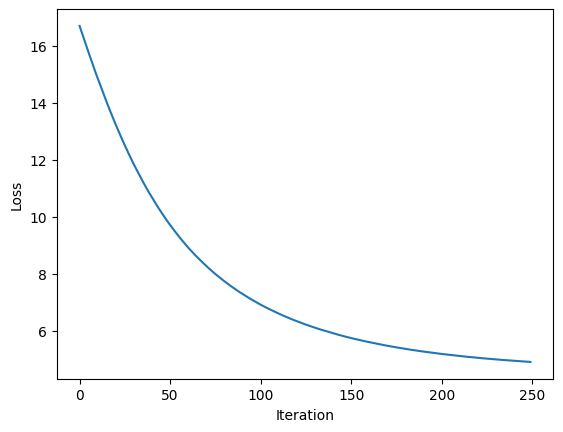

In [ ]:
print("Final loss:", losses[-1])
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(losses);

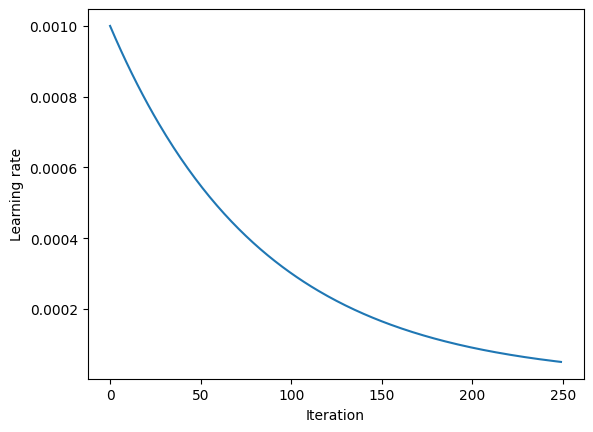

In [ ]:
plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.plot(lr_vals);

In [ ]:
from qutip import fidelity, Qobj

with th.no_grad():
    factors_unstacked = unstack(factors, N=N, M=M).to('cpu')
    pred_povm = th.matmul(factors_unstacked.conj().transpose(-1, -2), factors_unstacked)

    print(f"|| I - ΣAi†Ai ||2: {th.linalg.norm(th.eye(N) - sum(pred_povm), ord=2).item()}")
    print(f'Is predicted POVM valid? {"Yes" if check_povm_validity(pred_povm) else "No"}')

    print("Fidelities", [ th.real(fidelity(Qobj(pred_povm[i]), Qobj(true_povm[i]))**2 / (th.trace(true_povm[i])*th.trace(pred_povm[i]))).item() for i in range(M) ])
    print("Rel errors", [ 100*th.linalg.norm(pred_povm[i] - true_povm[i], ord="fro").item() / th.linalg.norm(true_povm[i], ord="fro").item() for i in range(M) ])
    print("Dist: ", sqrt(sum([ th.linalg.norm(pred_povm[i] - true_povm[i], ord="fro").item()**2 for i in range(M) ])) )
    print( "pred_pov - true_povm:", round(th.sum((pred_povm - th.stack(true_povm)) ** 2).item().real, 3) )
    pred_probs = th.einsum("bi,mij,bj->bm", probes.conj(), pred_povm.to(device), probes).real
    print(th.sum((pred_probs - targets) ** 2).item())
    print(povm_loss(targets.to(device), factors.to(device), probes.to(device), lam).item())

|| I - ΣAi†Ai ||2: 2.3778242840983506e-15
Is predicted POVM valid? Yes
Fidelities [0.28573639672141954, 0.12024815263504933, 0.0912022547941619, 0.06715313822429415, 0.06694420854163378, 0.04096112750010801, 0.044466756571501086, 0.0348855864510311, 0.03177729639178742, 0.03568484079249465, 0.04232207632117711, 0.03464154888754473, 0.03953042611346991, 0.04197419076281598, 0.03520433126973455, 0.03625273004694369, 0.03363290150533238, 0.04319467659513817, 0.02059381007981943, 0.04288927937755356]
Rel errors [57.30702886535769, 89.75704775185508, 95.02654158620199, 98.16983113327137, 97.5316305078051, 101.03343123794224, 100.23107494926168, 101.10563886843997, 102.08854172178978, 101.23218829734756, 100.21994780404412, 101.56978508300189, 100.71226841214684, 100.8639121422132, 101.15678531574976, 101.21680378839906, 101.82571050914247, 100.3329212135886, 103.66758090207338, 100.72893234244384]
Dist:  4.394878174506871
pred_pov - true_povm: 17.997
58.805947052305186
58.811531579285344


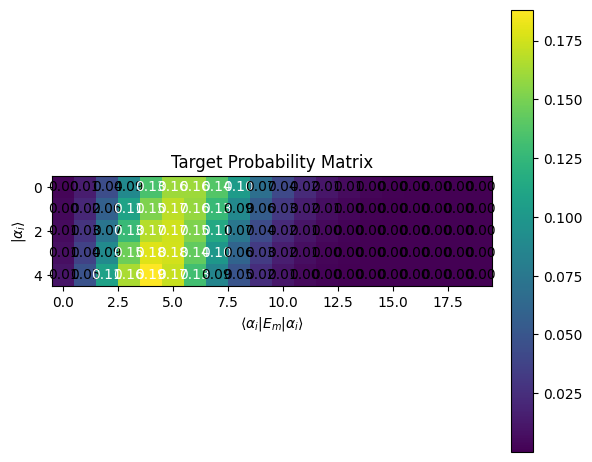

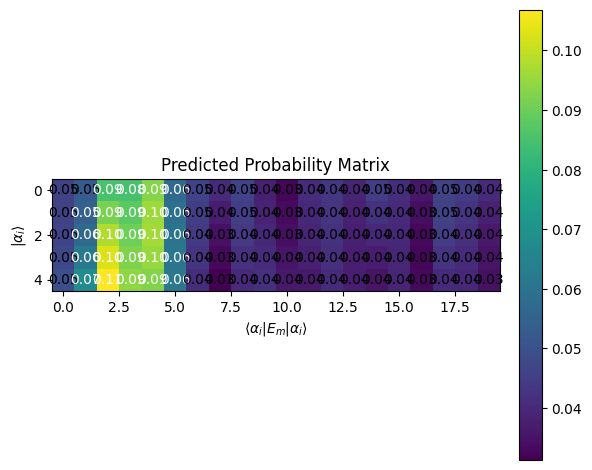

In [ ]:
plot_matrix(
    targets.cpu().numpy()[:5],
    title="Target Probability Matrix",
    cmap="viridis",
    show_values= not False,
    xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
    ylabel=r"$|\alpha_i\rangle$",
    colorbar=True,
    figsize=(6, 5),
    vmin=None,
    vmax=None
)

plot_matrix(
    pred_probs.cpu().numpy()[:5],
    title="Predicted Probability Matrix",
    cmap="viridis",
    show_values= not False,
    xlabel=r"$\langle \alpha_i|E_m|\alpha_i\rangle$",
    ylabel=r"$|\alpha_i\rangle$",
    colorbar=True,
    figsize=(6, 5),
    vmin=None,
    vmax=None
)